# Systems Immunogenetics Project

## West Nile Virus QTL Mapping, Haplotype Grouping, and Gene Candidate Workflow

### McWeeney Lab, Oregon Health & Science University

#### Author: Steve Chamberlin (chambest@ohsu.edu)

## Introduction

This document will walk through the steps for mapping QTLs in the RIX lines for an immune phenotype. After the QTL mapping, the founder effects in the locus will be clustered into high and low effect groups and variants matching the founders in these groups with be identified. And finally, protein coding regions in the locus that contain these variants will also be identified, as well as the predicted impact of the variant on the gene/protein function.

Required Files:

- This notebook** (`SIG_QTL_Mapping_HaplotypeGrouping_Workflow.ipynb`): [[Download here]](https://github.com/chambest/WNV_QTL_Resource/tree/main/Code)
- The R script (contains required R packages and custom functions) (`WNV_rix_qtl_mapping_functions_publication.r`): [[Download here]](https://github.com/chambest/WNV_QTL_Resource/tree/main/Code)
- File with Oas1b status for WNV mapping (`Oas1b_status_recoded.txt`): [[Download here]](https://figshare.com/account/items/28147985/edit)
- Phenotype data for this example (other tissue, time points, panels are in the same directory) (`PhenotypesWNV Spleen Treg D7.csv`): [[Download here]](https://figshare.com/account/items/28147976/edit)
- Universal model probabilities object (`rix_universal_model_prob_males_27-Jun-2016.rda`): [[Download here]](https://figshare.com/account/items/28147985/edit)
- Marker file (`CC001-Uncb38V01.csv`): [[Download here]](https://figshare.com/account/items/28147985/edit)
- Sanger VCF file for X chromosome (`mgp.v5.merged.snps_all.dbSNP142_chrX.recode.vcf.gz`): [[Download here]](https://figshare.com/account/items/28147958/edit)
- Sanger VCF index file for X chromosome (`mgp.v5.merged.snps_all.dbSNP142_chrX.recode.vcf.gz.tbi`): [[Download here]](https://figshare.com/account/items/28147958/edit)
- MGI annotation file (`mgi_annotation.rpt`): [[Download here]](https://figshare.com/account/items/28147991/edit)
- Uniprot annotation file (`MOUSE_10090_idmapping.dat`): [[Download here]](https://figshare.com/account/items/28147991/edit)



** Note: this notebook can also be downloaded as an R script (only the code blocks seen below will be included): [[Download R script here]](https://raw.githubusercontent.com/biodev/SIG/master/SIG_QTL_Mapping_HaplotypeGrouping_Workflow.r)

**All code is available on GitHub: https://github.com/chambest/WNV_QTL_Resource ** 

If you are not familiar with Jupyter Notebooks, Michael Mooney has created a short tutorial to get you up and running quickly. There is also plenty of documentation online:

1. [Jupyter for R Tutorial](http://nbviewer.jupyter.org/github/mooneymi/jupyter_notebooks/blob/master/r/Getting_Started_R.ipynb)
2. [Jupyter Documentation](http://jupyter.org/)
3. [Conda and R](https://www.continuum.io/conda-for-r)

#### Output

At the end, this workflow will output an R data file that contains a dataframe containing all of the variants found in the QTL interval that have been annotated with their predicted impact and whether they are contained in a protein coding region and the QTL object created from DOQTL.

## Step 1. Load Necessary R Functions and Libraries

In [1]:
## Load R functions and libraries
source('/Users/chambest/Documents/BACKUP/Shannons Work/Immunogenetics/Publications/QTL Paper/Nature Scientific Data/Workflows for Publication/Final Workflow/Code - Github/WNV_rix_qtl_mapping_functions_publication.r')

Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading 

## Step 2. Create Phenotype Dataframe

In [2]:
## Read phenotype data
cleaned_data_dir = '../Phenotypes'
pheno_dir = '../Phenotypes'
mapping_dir = '../Mapping'
data_dir = '../Output'

## For this example we're working with a Spleen Treg phenotype from day 7 post infection
pheno = read.csv(file.path(cleaned_data_dir, 'PhenotypesWNV Spleen Treg D7.csv'), header=T, as.is=T)
dim(pheno)

[1] 318  50

In [3]:
## The phenotype will be D7 WNV in spleen, treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen
pheno = pheno[with(pheno, Virus=='WNV' & Timepoint=='7' & Tissue=='spleen'), ]
dim(pheno)

[1] 318  50

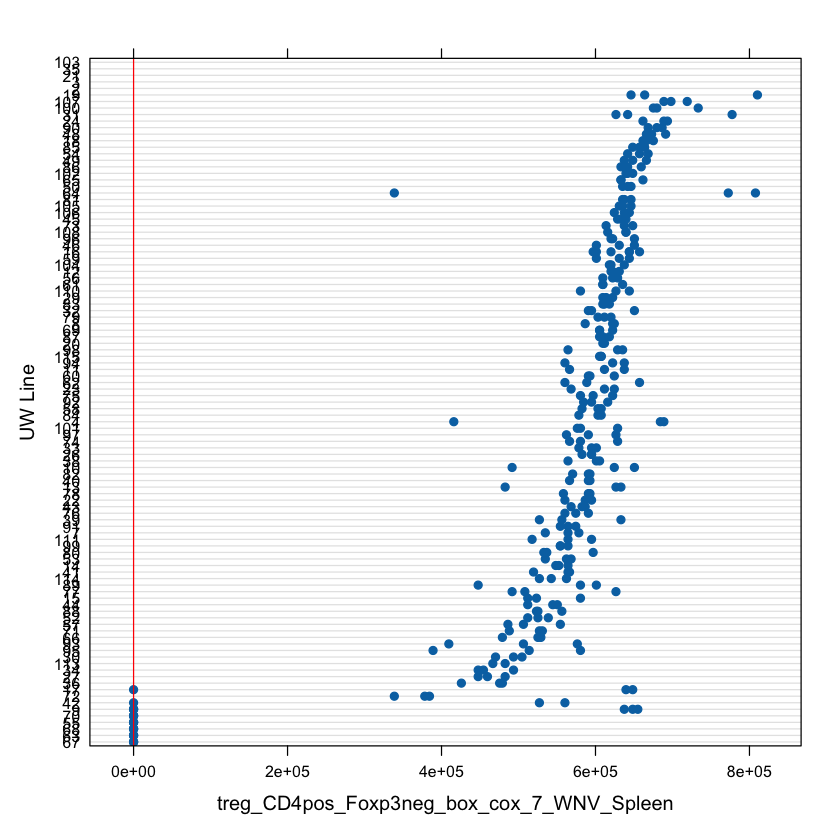

In [4]:
## View the phenotype distribution accross the mapping population
library(lattice)
dotplot(reorder(pheno[,'UW_Line'], pheno[,'treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen'], mean, na.rm=T) ~ 
        pheno[,'treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen'], 
        panel = function(x,y,...) {panel.dotplot(x,y,...); panel.abline(v=0, col.line="red")}, 
        pch=19, ylab='UW Line', xlab="treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen")


## Step 3. Update Phenotypes and Create Covariate Dataframe


In [5]:
## Sort pheno dataframe and set rownames
pheno = pheno[with(pheno, order(Mating, RIX_ID)),]
rownames(pheno) = pheno$ID

## Add sex column
pheno$sex = 'M'

In [6]:
## Create covariate dataframe (must include sex)
covar = data.frame(sex = as.numeric(pheno$sex == 'M'))
#covar = data.frame(sex = pheno$sex)
rownames(covar) = pheno$ID

In [7]:
## Get IDs and Matings for each sample
samples = pheno$ID
matings = unlist(lapply(strsplit(samples, '_'), function(x) {x[1]}))
matings = unique(matings)

In [8]:
## Read strain ID mapping file (with Oas1b status for WNV mapping analyses)
## Note: use the Mx1 file (linked at top) for Flu analyses
strain_map = read.delim(file.path(mapping_dir, 'Oas1b_status_recoded.txt'), header=T, as.is=T, sep='\t')
head(strain_map)

,Mating,CC_Mating,A,B,C,D,E,F,G,H,Null_prob,P_prob,WC_prob,Oas1b_status,Oas1b_High,Oas1b_Mod,Oas1b_Low
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>
1,13067x16912,CC003xCC051,1.000000e-20,1e-20,1.000000e-20,1.000000e-20,5e-01,1e-20,1e-20,5e-01,0.5,1e-20,5e-01,High,1,0,0
2,13067x5306,CC003xCC062,1.000000e-20,1e-20,1.995000e-07,4.999998e-01,1e-20,1e-20,1e-20,5e-01,0.5,1e-20,5e-01,High,1,0,0
3,13140x16680,CC001xCC055,1.000000e-20,5e-01,1.000000e-20,1.000000e-20,5e-01,1e-20,1e-20,1e-20,1.0,1e-20,2e-20,Low,0,0,1
4,13140x3015,CC001xCC074,1.000000e-20,5e-01,5.000000e-01,1.000000e-20,1e-20,1e-20,1e-20,1e-20,1.0,1e-20,2e-20,Low,0,0,1
5,13421x16034,CC007xCC070,1.000000e-20,1e-20,1.156000e-06,4.999988e-01,1e-20,1e-20,5e-01,1e-20,0.5,5e-01,2e-20,Mod,0,1,0
6,13421x3260,CC007xCC075,4.999744e-01,1e-20,2.680125e-05,4.999988e-01,1e-20,1e-20,1e-20,1e-20,1.0,1e-20,2e-20,Low,0,0,1


In [9]:
## Check that matings match the strain mapping file
setdiff(matings, strain_map$Mating)

character(0)

In [10]:
## Update covar with Oas1b status (only for WNV analyses)
covar$Mating = pheno$Mating
covar$Oas1b = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b[strain_map$Mating == x] else NA})
covar$Oas1b_High = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b_High[strain_map$Mating == x] else NA})
covar$Oas1b_Mod = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b_Mod[strain_map$Mating == x] else NA})
covar$Oas1b_Low = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b_Low[strain_map$Mating == x] else NA})
pheno$Oas1b = covar$Oas1b
pheno$Oas1b_High = covar$Oas1b_High
pheno$Oas1b_Mod = covar$Oas1b_Mod
pheno$Oas1b_Low = covar$Oas1b_Low

## Step 4. Construct 3D Array of Probabilities

In [11]:
## Load universal model probabilities (loads a model.probs object containing all RIX lines)
load(file.path(mapping_dir, 'rix_universal_model_prob_males_27-Jun-2016.rda'))

In [12]:
## Create model.probs array specific to the mapping population
model.probs = model.probs[pheno$Mating, , ]
dimnames(model.probs)[[1]] = pheno$ID

In [13]:
## Check model.probs object
dim(model.probs)
names(dimnames(model.probs))
dim(model.probs)[1] == dim(pheno)[1]
model.probs[1,,1:5]

[1]   318     8 76600

[1] "samples"  "founders" "markers"

[1] TRUE

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,6.000000e-06,5.25000e-06,4.500000e-06,3.750000e-06,3.000000e-06
B,4.999962e-01,4.99997e-01,4.999977e-01,4.999981e-01,4.999985e-01
C,4.200000e-08,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
D,4.200000e-08,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
E,4.999961e-01,4.99997e-01,4.999977e-01,4.999981e-01,4.999985e-01
F,4.200000e-08,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
G,4.200000e-08,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
H,1.500750e-06,7.50750e-07,7.500000e-10,7.500000e-10,1.000000e-20


In [14]:
## Fix very small genotype probabilities
model.probs[model.probs < 0.005] = 1e-20

In [15]:
## Check model.probs object
model.probs[1,,1:5]

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,1.000000e-20,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
B,4.999962e-01,4.99997e-01,4.999977e-01,4.999981e-01,4.999985e-01
C,1.000000e-20,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
D,1.000000e-20,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
E,4.999961e-01,4.99997e-01,4.999977e-01,4.999981e-01,4.999985e-01
F,1.000000e-20,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
G,1.000000e-20,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20
H,1.000000e-20,1.00000e-20,1.000000e-20,1.000000e-20,1.000000e-20


## Step 5. Calculate Kinship Matrix

In [16]:
## Create kinship probability matrix
K = kinship.probs(model.probs)

SNP 0
SNP 1000
SNP 2000
SNP 3000
SNP 4000
SNP 5000
SNP 6000
SNP 7000
SNP 8000
SNP 9000
SNP 10000
SNP 11000
SNP 12000
SNP 13000
SNP 14000
SNP 15000
SNP 16000
SNP 17000
SNP 18000
SNP 19000
SNP 20000
SNP 21000
SNP 22000
SNP 23000
SNP 24000
SNP 25000
SNP 26000
SNP 27000
SNP 28000
SNP 29000
SNP 30000
SNP 31000
SNP 32000
SNP 33000
SNP 34000
SNP 35000
SNP 36000
SNP 37000
SNP 38000
SNP 39000
SNP 40000
SNP 41000
SNP 42000
SNP 43000
SNP 44000
SNP 45000
SNP 46000
SNP 47000
SNP 48000
SNP 49000
SNP 50000
SNP 51000
SNP 52000
SNP 53000
SNP 54000
SNP 55000
SNP 56000
SNP 57000
SNP 58000
SNP 59000
SNP 60000
SNP 61000
SNP 62000
SNP 63000
SNP 64000
SNP 65000
SNP 66000
SNP 67000
SNP 68000
SNP 69000
SNP 70000
SNP 71000
SNP 72000
SNP 73000
SNP 74000
SNP 75000
SNP 76000


In [17]:
## Garbage collection might help free memory
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,11855663,633.2,17083707,912.4,NA,15618811,834.2
Vcells,215652520,1645.3,609506643,4650.2,18432,605863723,4622.4


In [18]:
## Check kinship matrix
K[1:5, 1:5]

,13067x16912_142,13067x16912_157,13067x16912_158,13067x5306_81,13067x5306_82
13067x16912_142,1.0000000,1.0000000,1.0000000,0.5946385,0.5946385
13067x16912_157,1.0000000,1.0000000,1.0000000,0.5946385,0.5946385
13067x16912_158,1.0000000,1.0000000,1.0000000,0.5946385,0.5946385
13067x5306_81,0.5946385,0.5946385,0.5946385,1.0000000,1.0000000
13067x5306_82,0.5946385,0.5946385,0.5946385,1.0000000,1.0000000


## Step 6. Perform QTL Scan

In [19]:
## First get marker positions
marker_pos = read.csv(file.path(mapping_dir, 'CC001-Uncb38V01.csv'), as.is=T)
marker_pos = marker_pos[,1:3]
marker_pos$position_cM = NA
head(marker_pos)

,marker,chromosome,position.B38.,position_cM
,<chr>,<chr>,<int>,<lgl>
1,UNC6,1,3010274,NA
2,JAX00000010,1,3135418,NA
3,JAX00240603,1,3252796,NA
4,JAX00240610,1,3266608,NA
5,JAX00240613,1,3323400,NA
6,JAX00240636,1,3389563,NA


In [20]:
## Run QTL scan
qtl = scanone(pheno=pheno, pheno.col='treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen', probs=model.probs, K=K, 
              addcovar=covar[, c("Oas1b_High", "Oas1b_Mod",'sex'), drop=F], snps=marker_pos)

[1] "Mapping with 318 samples."
[1] "Mapping with 76600 markers."
[1] "treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen"


In [21]:
## Run permutations to calculate significance threshold
## Note: nperm=10 is for demonstration purposes only. Normally, at least 1000 permutations should be done.
perms = scanone.perm(pheno=pheno, pheno.col='treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen', probs=model.probs, 
                     addcovar=covar[, c('sex', "Oas1b_High", "Oas1b_Mod"), drop=F], snps=marker_pos, nperm = 10)

[1] "treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen"
[1] "1 of 10"
[1] "2 of 10"
[1] "3 of 10"
[1] "4 of 10"
[1] "5 of 10"
[1] "6 of 10"
[1] "7 of 10"
[1] "8 of 10"
[1] "9 of 10"
[1] "10 of 10"
[1] "1 of 10"
[1] "2 of 10"
[1] "3 of 10"
[1] "4 of 10"
[1] "5 of 10"
[1] "6 of 10"
[1] "7 of 10"
[1] "8 of 10"
[1] "9 of 10"
[1] "10 of 10"


In [22]:
## Get the significance thresholds
sig.thr = get.sig.thr(perms[,,'treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen'], alpha=0.05)
sugg.thr = get.sig.thr(perms[,,'treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen'], alpha=0.1)
med.thr = get.sig.thr(perms[,,'treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen'], alpha=0.5)

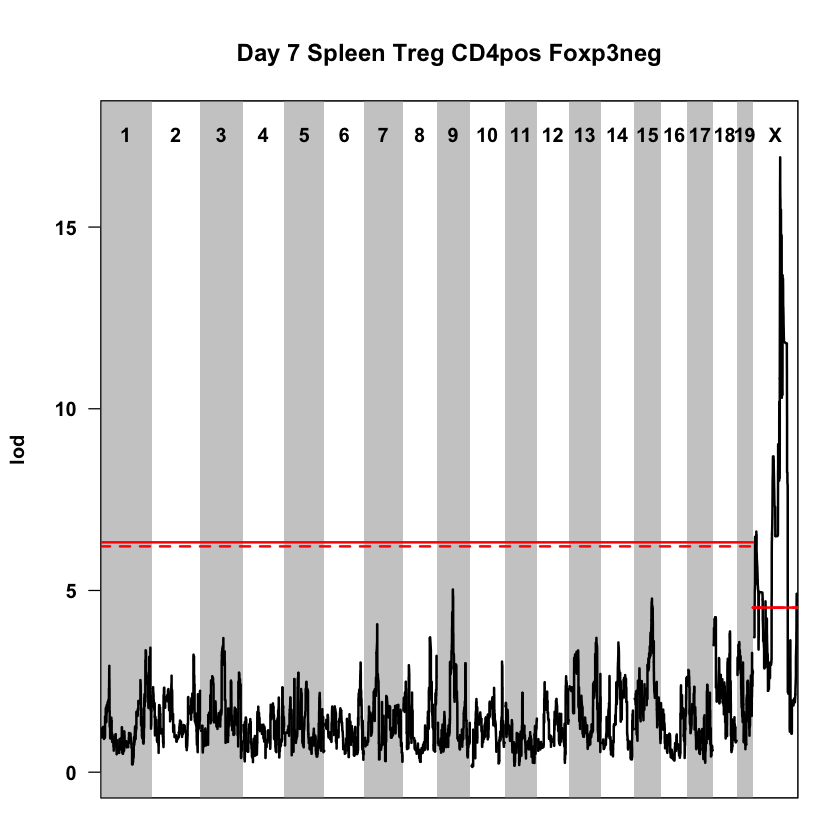

In [23]:
## Plot QTL results
plot(qtl, sig.thr = sig.thr, main = 'Day 7 Spleen Treg CD4pos Foxp3neg')

## Add lines for suggestive peaks (alpha = 0.1)
lines(x = c(0, 2462), y = rep(sugg.thr[1,"A"], 2), lwd = 2, lty=2, col = 'red')
lines(x = c(2462, 2633), y = rep(sugg.thr[1,"X"], 2), lwd = 2, lty=2, col = 'red')

## Step 7. Identify QTL Intervals

In [24]:
## Identify the Bayes Credible Interval for the peak on chromosome X
interval = bayesint_v2(qtl, chr = 'X')
interval

,marker,chromosome,position.B38.,position_cM,perc.var,lrs,lod,p,neg.log10.p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75857,UNC31156076,X,102.2976,NA,19.98292,67.77075,14.71623,4.163667e-12,11.38052
75868,XiB1,X,102.7565,NA,22.60784,77.91054,16.91806,3.671245e-14,13.43519
75943,JAX00183066,X,107.4665,NA,20.06235,68.07266,14.78179,3.619093e-12,11.44140


## Step 8. Create a Coefficient Plot and Probability Plot for Significant Peaks

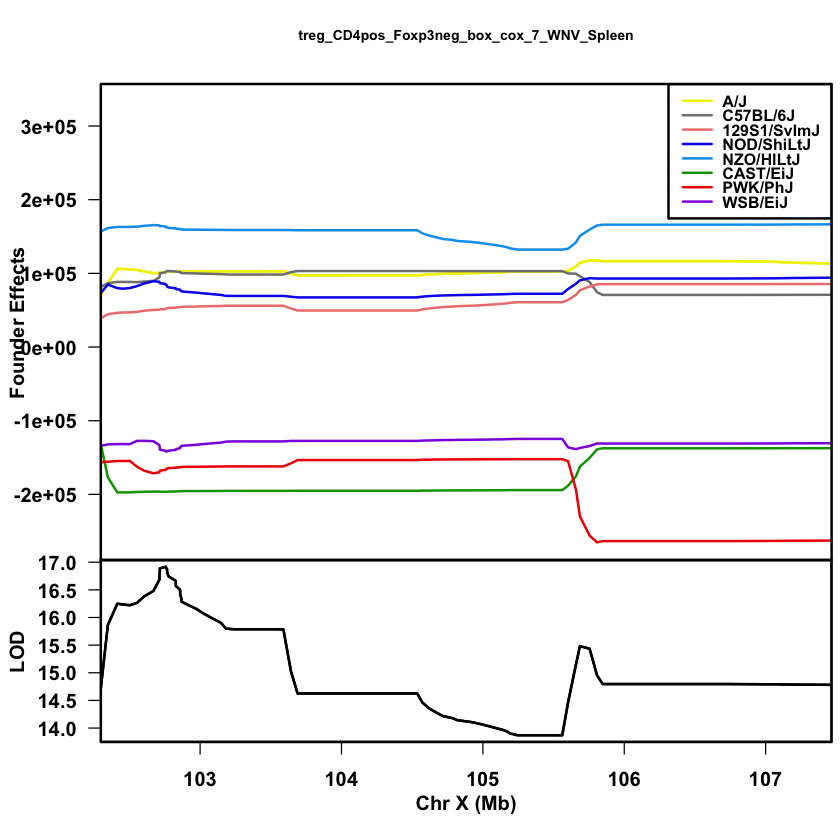

In [25]:
## Create founder effects (coefficient) plot for peak interval
coefplot_v2(qtl, chr='X', start=interval[1,3], end=interval[3,3], sex='F', main='treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen', cex.main=.7)

In [26]:
## Get marker at peak
get_min_marker(qtl, chr='X')

,marker,chromosome,position.B38.,position_cM,perc.var,lrs,lod,p,neg.log10.p
,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75868,XiB1,X,102.7565,NA,22.60784,77.91054,16.91806,3.671245e-14,13.43519


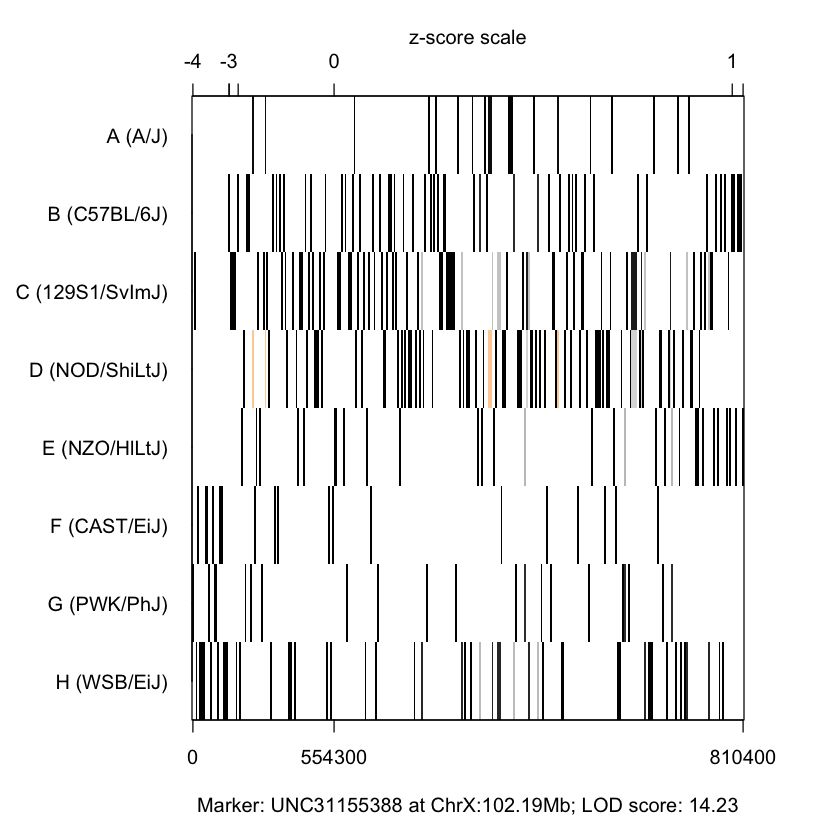

In [27]:
## Create probability plot
phenoclass="Treg Spleen Day 7" #used in report title names
prob.plot(pheno=pheno, pheno.col='treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen', probs=model.probs, marker='UNC31155388', qtl=qtl)

## Step 9. Run haplotype groupings, identify variants of interest in QTL interval, and identify gene candidates

In [ ]:
phenocol<-'treg_CD4pos_Foxp3neg_box_cox_7_WNV_Spleen'
phenocolend="WNV_Spleen"
untransphenocol<-substr(phenocol,1,str_locate(phenocol,phenocolend)[,1]-2)
start=interval[1,3]
end=interval[3,3]
sex='M'
outputdir=data_dir
chr='X'
FoundProbAssocPlotsComplexShort_Publication(phenocol=phenocol,untransphenocol=untransphenocol,sex=sex,chr=chr,start=start,end=end,qtl=qtl) 
